In [ ]:
!pip install -q timm pytorch-metric-learning

     |████████████████████████████████| 431 kB 30.5 MB/s 
     |████████████████████████████████| 110 kB 64.0 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import numpy as np
import time
import torch
import copy
from PIL import Image
from tqdm.notebook import trange, tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
from pytorch_metric_learning import losses
import timm
from torch.cuda import amp
from collections import defaultdict
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class Wound_Dataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Wound dataset. Returns tensorized images with
        corresponding class 1: healer, 0: nonhealer
        Args:
            root_dir: path to healer/nonhealer image dataset.
        """
        self.root_dir = root_dir
        self.transform = transform 
        self.samples, self.targets = self.make_dataset(self.root_dir)

    def make_dataset(self, root_dir):
 
        instances = []
        targets = []


        for i in os.listdir(root_dir):
            instances.append(root_dir + "/" + i)
            # print(df[df['Filename'] == i]['Label_bin'])
            # print(i)
            label = i.split('_')[2].split('.')[0]
            if label == 'NonHealer':
                targets.append(0)
            elif label == 'Healer':
                targets.append(1)

        print(instances)
        print(targets)

        return instances, targets

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            img = img.convert('RGB')
            img = img.resize((224,224), Image.BICUBIC)
            return img

    def __getitem__(self, index: int):
            """
            Returns tensor data and label.
            Args:
                index (int): Index
            Returns:
                tuple: (sample, target) where sample is a tensor of input data
                        target is class of sample.
            """
            # Get images and targets, drop alpha
            img = self.pil_loader(self.samples[index])
            target = self.targets[index]

            # print(img.size)
            # print(self.samples[index])

            if self.transform:
                img = self.transform(img)

            # Concat and return sample, target
            return img , target

    def __len__(self):
        return len(self.samples)

In [ ]:
def wound_dataloader(dataset, batch_size: int, num_workers = 0, shuffle = True, pin_memory = False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory)

In [ ]:
# class Encoder(nn.Module):
#     """
#     Encoder model Pytorch. 
#     """   
#     def __init__(self):
#         # Initialize self._modules as OrderedDict
#         super(Encoder, self).__init__() 
#         # Initialize densenet121
#         self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
#         # Remove Classifying layer
#         self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
#         # 7x7 average pool layer
#         self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
#         # Left image connected layers
#         self.fc_16 = nn.Linear(1024, 16)


#     def forward(self, x):
#         # Embed Left
#         u1 = self.embed_model(x)
#         u1 = self.avg(u1)
#         u1 = u1.view(-1,1024)
#         u1 = self.fc_16(u1)
#         #u1 = torch.relu(u1)
#         return u1

#     def load_embed_wts(self, device):
#         """
#         load pretrained model weights, use only when transfer learning from ImageNET data
#         """
#         # Initialize densenet121
#         self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)

#         # Remove Classifying layer
#         self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])


# # class SupConClassifier(nn.Module):
# #     def __init__(self):
# #         super(SupConClassifier, self).__init__()
# #         self.encoder = Encoder()
# #         for param in self.encoder.parameters():
# #             param.requires_grad = False
# #         self.projection1 = nn.Linear(16, 16, bias=True)
# #         self.bn = nn.BatchNorm1d(16)
# #         # self.idt = nn.Identity()
# #         self.relu = nn.ReLU()
# #         self.projection2 = nn.Linear(16, 4, bias=True)
# #         self.bn1 = nn.BatchNorm1d(4)
# #         self.classifier = nn.Linear(4, 2, bias=True)

# #     def forward(self, x):
# #         u = self.encoder(x)
# #         u = self.projection1(u)
# #         u = self.bn(u)
# #         u = self.relu(u)
# #         u = self.projection2(u)
# #         u = self.relu(u)
# #         u = self.bn1(u)
# #         u = self.classifier(u)
# #         return u

# class Projection(nn.Module):
#     """
#     Creates projection head
#     Args:
#         n_in (int): Number of input features
#         n_hidden (int): Number of hidden features
#         n_out (int): Number of output features
#         use_bn (bool): Whether to use batch norm
#     """
#     def __init__(self, n_in: int, n_hidden: int, n_out: int,
#                 use_bn: bool = True):
#         super().__init__()
        
#         # No point in using bias if we've batch norm
#         self.lin1 = nn.Linear(n_in, n_hidden, bias=not use_bn)
#         self.bn = nn.BatchNorm1d(n_hidden) if use_bn else nn.Identity()
#         self.relu = nn.ReLU()
#         # No bias for the final linear layer
#         self.lin2 = nn.Linear(n_hidden, n_out, bias=False)
    
#     def forward(self, x):
#         x = self.lin1(x)
#         x = self.bn(x)
#         x = self.relu(x)
#         x = self.lin2(x)
#         return x

# class SupConClassifier(nn.Module):
#     def __init__(self, projection_n_in: int = 16,
#                projection_n_hidden: int = 16, projection_n_out: int = 16,
#                projection_use_bn: bool = True):
#         super().__init__()
        
#         self.encoder = Encoder()
#         for param in self.encoder.parameters():
#             param.requires_grad = False
#         self.projection = Projection(projection_n_in, projection_n_hidden,
#                                     projection_n_out, projection_use_bn)
  
#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.projection(x)
#         return x

# class Classifier(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.selfsup = SupConClassifier()
#         self.middle = nn.Linear(16,4)
#         # self.relu = nn.ReLU()
#         self.classifier = nn.Linear(4,2)

#     def forward(self, x):
#         x = self. selfsup(x)
#         x = self. middle(x)
#         # x = self. middle(x)
#         x = self.classifier(x)

#         return x


In [ ]:
class Encoder(nn.Module):
    """
    Encoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(Encoder, self).__init__() 
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
        # 7x7 average pool layer
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        # Left image connected layers
        self.fc_16 = nn.Linear(1024, 16)


    def forward(self, x):
        # Embed Left
        u1 = self.embed_model(x)
        u1 = self.avg(u1)
        u1 = u1.view(-1,1024)
        u1 = self.fc_16(u1)
        #u1 = torch.relu(u1)
        return u1

    def load_embed_wts(self, device):
        """
        load pretrained model weights, use only when transfer learning from ImageNET data
        """
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)

        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])

class Projection(nn.Module):
    """
    Creates projection head
    Args:
        n_in (int): Number of input features
        n_hidden (int): Number of hidden features
        n_out (int): Number of output features
        use_bn (bool): Whether to use batch norm
    """
    def __init__(self, n_in: int, n_hidden: int, n_out: int,
                use_bn: bool = True):
        super().__init__()
        
        # No point in using bias if we've batch norm
        self.lin1 = nn.Linear(1024, 1024, bias = True)
        self.bn = nn.BatchNorm1d(1024)
        self.relu = nn.ReLU()
        # No bias for the final linear layer
        self.lin2 = nn.Linear(1024, 128, bias=False)
    
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.lin2(x)
        return x

class SupConClassifier(nn.Module):
    def __init__(self, projection_n_in: int = 16,
               projection_n_hidden: int = 16, projection_n_out: int = 16,
               projection_use_bn: bool = True):
        super().__init__()
        
        # self.encoder = Encoder()
        self.pre_encoder = Encoder()
        self.encoder = nn.Sequential(*list(self.pre_encoder.children())[:-1])

        for param in self.encoder.parameters():
            param.requires_grad = False
        self.projection = Projection(projection_n_in, projection_n_hidden,
                                    projection_n_out, projection_use_bn)
  
    def forward(self, x):
        x = self.encoder(x)
        x = self.projection(x)
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.selfsup = SupConClassifier()
        self.middle = nn.Linear(128,32)
        # self.relu = nn.ReLU()
        # self.classifier = nn.Linear(4,2)

    def forward(self, x):
        x = self. selfsup(x)
        x = self. middle(x)
        # x = self. middle(x)
        # x = self.classifier(x)

        return x

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            # model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase],desc='batches', leave = False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    outputs = nn.functional.normalize(outputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
            # if phase == 'val':
            #     val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224 # Muse be 224 (3x224x224) for Densenet121

# Standard Pytorch image transforms (source:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        # transforms.RandomResizedCrop(input_size),
        # transforms.RandomRotation(degrees=(0,360)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        # transforms.RandomResizedCrop(input_size),
        # transforms.RandomRotation(degrees=(0,360)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Hyper Parameters:
# data_path = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Infected_Uninfected_Circular_Cropped/dataset" #path to Wound_images
data_path = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_V2/"
learning_rate = 0.001
weight_decay = 0.1
batch_size = 33
num_epochs = 25

# Generate Datasets & Loaders
data_loaders_dict = {phase: wound_dataloader(Wound_Dataset(data_path+"/"+phase, transform=data_transforms[phase]), 
                                             batch_size, num_workers = 0, shuffle = True, pin_memory = True) for phase in ['train', 'val']}

# Create Model
model = SupConClassifier()
model.to(device)
# model.load_encoder_wts(device)
path_to_wts = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/meta_learned_ENCODER.tar" # Path to encoder wts
# model.selfsup.encoder.load_state_dict(torch.load(path_to_wts))
model.pre_encoder.load_state_dict(torch.load(path_to_wts))

# Specify optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# lossfun = nn.CrossEntropyLoss()
# lossfun = SupervisedContrastiveLoss()
lossfun = losses.SupConLoss(temperature = 0.1).to(device)

FileNotFoundError: ignored

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+--------------------------+------------+
|         Modules          | Parameters |
+--------------------------+------------+
| pre_encoder.fc_16.weight |   16384    |
|  pre_encoder.fc_16.bias  |     16     |
|  projection.lin1.weight  |  1048576   |
|   projection.lin1.bias   |    1024    |
|   projection.bn.weight   |    1024    |
|    projection.bn.bias    |    1024    |
|  projection.lin2.weight  |   131072   |
+--------------------------+------------+
Total Trainable Params: 1199120


1199120

In [ ]:
# print(model)

In [ ]:
healnet, hist = train_model(model, data_loaders_dict, criterion=lossfun, optimizer = optimizer, num_epochs=num_epochs)

Epoch 0/24
----------


batches:   0%|          | 0/1 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
classification_model = Classifier()

### EXTRAS

In [ ]:
# class SupervisedContrastiveLoss(nn.Module):
#     def __init__(self, temperature=0.1):
#         super(SupervisedContrastiveLoss, self).__init__()
#         self.temperature = temperature

#     def forward(self, feature_vectors, labels):
#         # Normalize feature vectors
#         feature_vectors_normalized = F.normalize(feature_vectors, p=2, dim=1)
#         # Compute logits
#         logits = torch.div(
#             torch.matmul(
#                 feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
#             ),
#             self.temperature,
#         )
#         return losses.NTXentLoss(temperature=0.07)(logits, torch.squeeze(labels))

In [ ]:
save_as = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/Contrastive_Encoder_June_15" # path and name of trained healNet weights
torch.save(healnet.state_dict(), save_as)

### SALIENCY MAP

In [ ]:
healnet = HealNet()
healnet.to(device)
# healnet.load_encoder_wts(device)
path_to_healnet = "/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Weights/meta_learned.tar" # Path to healnet weights
healnet.load_state_dict(torch.load(path_to_healnet))

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


<All keys matched successfully>

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import requests
from PIL import Image

In [ ]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

    # transforms.Resize(input_size),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [ ]:
img = Image.open('/content/drive/MyDrive/HealNet/Healer vs. Non Healer/Few_Shot_Learning_Data/support_set/Patient19_Day1_NonHealer.png') 

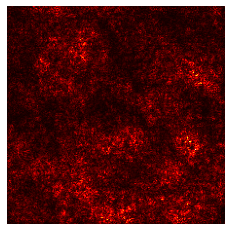

In [ ]:
# preprocess the image
X = preprocess(img)

# we would run the model in evaluation mode
healnet.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

scores = healnet(X.cuda())

# Get the index corresponding to the maximum score and the maximum score itself.
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

# code to plot the saliency map as a heatmap
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()